In [64]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


width of 13,314 pixels and a height of 6,081 pixels.

In [74]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import numpy as np

# Open the raster file
file_path = "amerob/amerob_abundance_median_2022-09-06.tif"
with rasterio.open(file_path) as src:
    # Reproject to WGS84
    dst_crs = 'EPSG:4326'  # WGS84
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('reprojected.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


with rasterio.open('reprojected.tif') as dataset:
    data = dataset.read(1) 
    transform_affine = dataset.transform 

    # Get the coordinates of each pixel
    rows, cols = np.indices(data.shape)
    xs = transform_affine[2] + cols * transform_affine[0] + rows * transform_affine[1]
    ys = transform_affine[5] + cols * transform_affine[3] + rows * transform_affine[4]
    
    # Flatten the arrays
    xs = xs.flatten()
    ys = ys.flatten()
    values = data.flatten()

    # Create a DataFrame
    df = pd.DataFrame({
        'longitude': xs,
        'latitude': ys,
        'value': values
    })
df

,longitude,latitude,value
0,-180.000000,90.000000,NaN
1,-179.973355,90.000000,NaN
2,-179.946710,90.000000,NaN
3,-179.920065,90.000000,NaN
4,-179.893420,90.000000,NaN
...,...,...,...
76066925,179.866775,-59.984462,NaN
76066926,179.893420,-59.984462,NaN
76066927,179.920065,-59.984462,NaN
76066928,179.946710,-59.984462,NaN


Filter the DataFrame based on the specified latitude and longitude range <br>
Replace NaN values with 0. <br>
Convert to Integer <br>
Clip values above 100

In [132]:
filtered_df = df[
    (df['latitude'] >= 24.75) & (df['latitude'] <= 49.25) &
    (df['longitude'] >= -124.75) & (df['longitude'] <= -67.25)
]
amerob = filtered_df.fillna(0).pivot_table(index='latitude', columns='longitude', values='value', aggfunc='mean')
amerob = np.ceil(amerob).astype(int)
# amerob = amerob.applymap(lambda x: min(x, 100))
amerob = amerob.clip(upper=30)
amerob

longitude,-124.738361,-124.711716,-124.685071,-124.658426,-124.631782,-124.605137,-124.578492,-124.551847,-124.525202,-124.498557,...,-67.504996,-67.478351,-67.451706,-67.425061,-67.398416,-67.371771,-67.345126,-67.318481,-67.291836,-67.265191
latitude,,,,,,,,,,,,,,,,,,,,,
24.773146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.799790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.826435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.853080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24.879725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49.126636,4,3,3,3,3,3,4,3,3,3,...,0,0,0,0,0,0,0,0,0,0
49.153281,3,3,4,4,4,3,4,3,3,3,...,0,0,0,0,0,0,0,0,0,0
49.179926,3,4,4,4,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# Resetting the index to replace lat/lon with normal integer index
amerob = amerob.reset_index(drop=True)

# Rename columns to integer indices
amerob.columns = range(amerob.shape[1])

amerob

,0,1,2,3,4,5,6,7,8,9,...,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,4,3,3,3,3,3,4,3,3,3,...,0,0,0,0,0,0,0,0,0,0
915,3,3,4,4,4,3,4,3,3,3,...,0,0,0,0,0,0,0,0,0,0
916,3,4,4,4,3,3,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
917,3,3,3,3,3,3,3,3,3,4,...,0,0,0,0,0,0,0,0,0,0


In [144]:
import pandas as pd
import numpy as np
import scipy.ndimage

# Your original data as a numpy array
data = amerob.to_numpy()

# Rescale the data using interpolation
rescaled_data = scipy.ndimage.zoom(data, (392 / data.shape[0], 920 / data.shape[1]), order=1)

# Convert back to DataFrame
amerob_rescaled = pd.DataFrame(rescaled_data)

# Round the values and convert to integers
amerob_rescaled = np.ceil(amerob_rescaled).astype(int)

amerob_rescaled.to_parquet('amerob_2022-09-06.parquet')
amerob_rescaled


,0,1,2,3,4,5,6,7,8,9,...,910,911,912,913,914,915,916,917,918,919
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,3,3,4,4,4,4,4,4,4,5,...,0,0,0,0,0,0,0,0,0,0
388,3,3,4,3,4,4,4,4,4,4,...,0,0,0,0,0,0,0,0,0,0
389,3,3,3,4,4,3,4,4,3,4,...,0,0,0,0,0,0,0,0,0,0
390,3,4,3,3,3,4,4,4,3,3,...,0,0,0,0,0,0,0,0,0,0


In [137]:
data = amerob.to_numpy()

# Calculate the exact block size for rows and columns
row_block_size = data.shape[0] // 392  # Integer division to get the block size
col_block_size = data.shape[1] // 920  # Integer division to get the block size

# Slice the array to match exact multiples if necessary
data = data[:392 * row_block_size, :920 * col_block_size]

# Reshape and sum over the blocks
rescaled_data = data.reshape(392, row_block_size, 920, col_block_size).sum(axis=(1, 3))

# Convert the rescaled numpy array back to a DataFrame
amerob_rescaled = pd.DataFrame(rescaled_data)

# Multiply all values by the scaling number
scaling_number = 1  
amerob_rescaled = np.ceil(amerob_rescaled * scaling_number).astype(int)
# amerob_rescaled_scaled

amerob_rescaled.to_parquet('amerob_2022-09-06.parquet')
amerob_rescaled

,0,1,2,3,4,5,6,7,8,9,...,910,911,912,913,914,915,916,917,918,919
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0,0,0,0,0,0,0,0,0,0,...,8,8,8,11,11,10,8,10,9,9
388,0,0,0,0,0,0,0,0,0,0,...,8,12,11,9,9,8,10,10,11,12
389,0,0,0,0,0,0,0,0,0,0,...,9,10,8,8,8,8,8,7,8,12
390,0,0,0,0,0,0,0,0,0,0,...,9,10,8,7,6,4,5,6,8,8


The largest number in the data is: 30


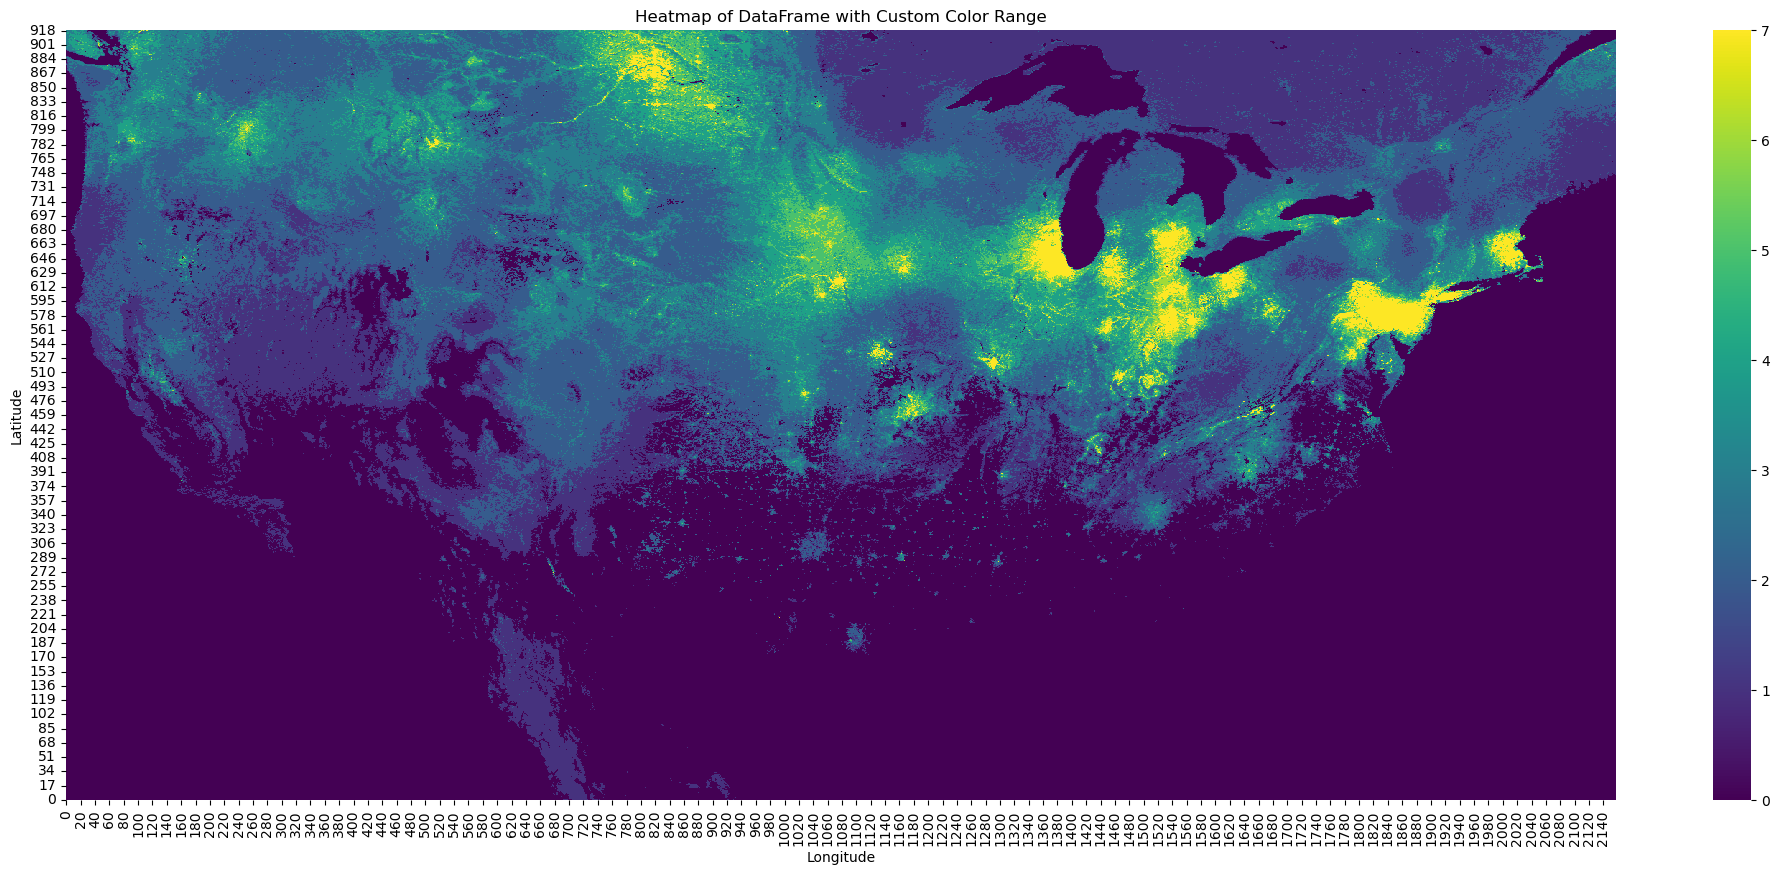

In [145]:
# Find the maximum value in the DataFrame
max_value = data.max().max()
print(f"The largest number in the data is: {max_value}")

# Reverse the order of the latitude index
data_reversed = amerob.iloc[::-1]

# Set the color range with the maximum value
plt.figure(figsize=(25, 10))
sns.heatmap(data_reversed, cmap="viridis", cbar=True, vmin=0, vmax=7)

plt.title("Heatmap of DataFrame with Custom Color Range")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


The largest number in the data is: 30


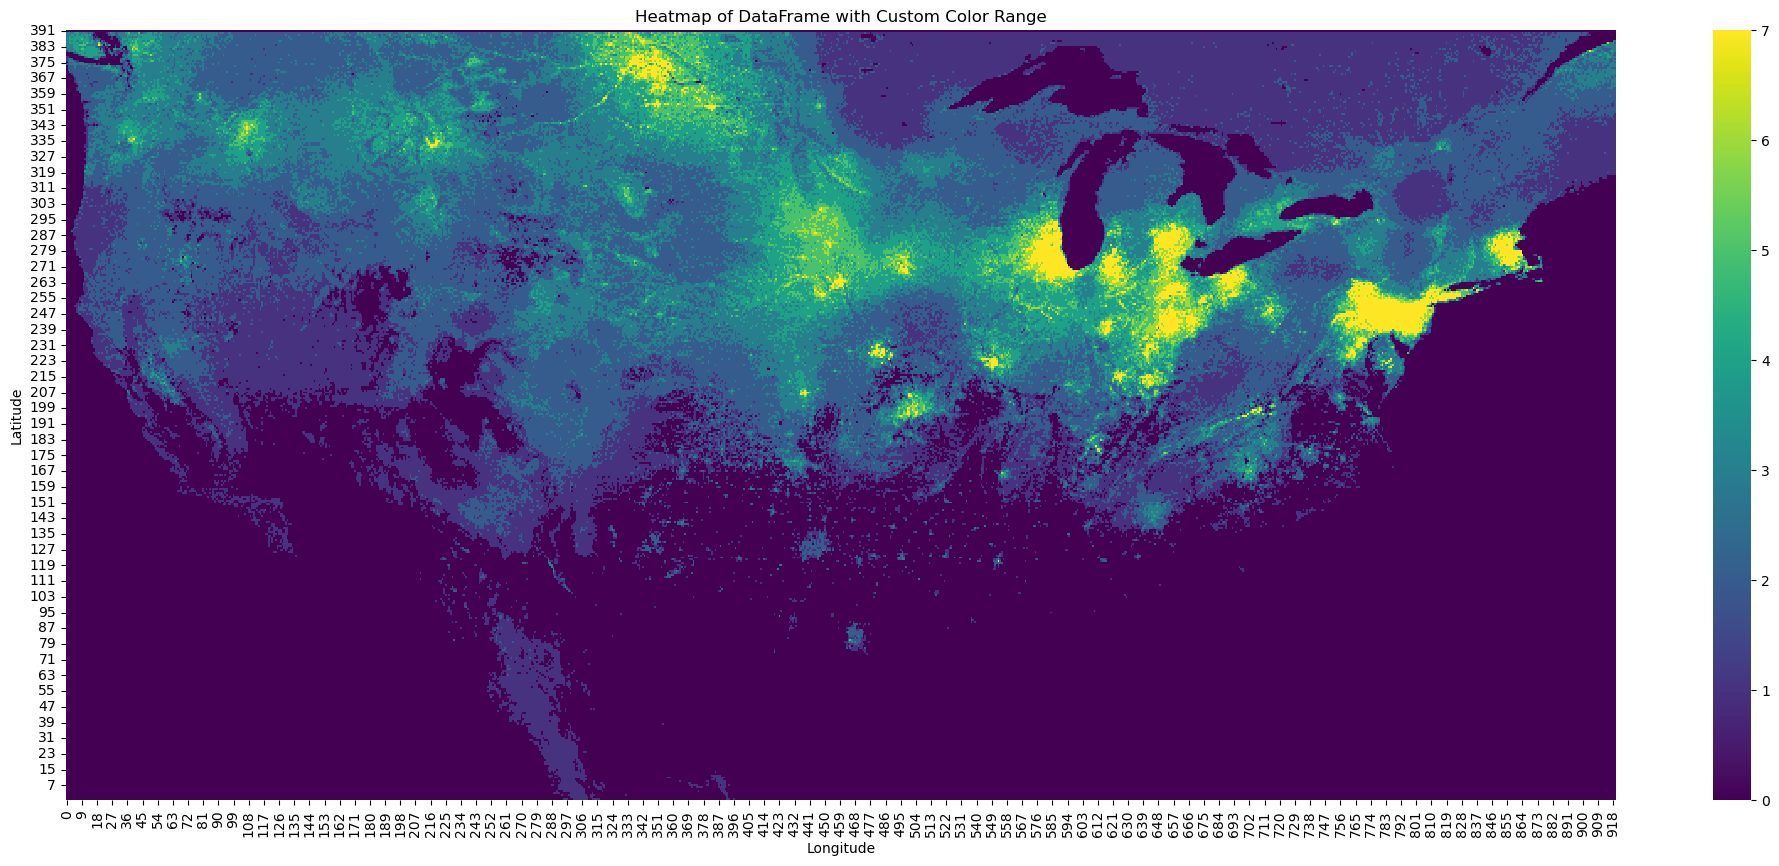

In [146]:
# Find the maximum value in the DataFrame
max_value = data.max().max()
print(f"The largest number in the data is: {max_value}")

# Reverse the order of the latitude index
data_reversed = amerob_rescaled.iloc[::-1]

# Set the color range with the maximum value
plt.figure(figsize=(25, 10))
sns.heatmap(data_reversed, cmap="viridis", cbar=True, vmin=0, vmax=7)

plt.title("Heatmap of DataFrame with Custom Color Range")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [142]:
amerob.sum().sum()

2351142

In [141]:
amerob_rescaled.sum().sum()

424620